# Strategy 6 - LSTM for Price Prediction

Dans ce notebook, nous allons implémenter et tester une stratégie basée sur un LSTM pour la prédiction des prix. Cette architecture plus sophistiquée devrait théoriquement mieux capturer les dépendances à long terme dans les séries temporelles.

In [1]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

In [2]:
from strategies.lstm_strategy import LSTMStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data_handler = DataHandler(ticker='AAPL', start_date='2010-01-01', end_date='2022-01-01')
data = data_handler.fetch_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



In [4]:
# Création et entraînement de la stratégie LSTM
lstm_strategy = LSTMStrategy(n_days=1, predict_returns=False)
signals = lstm_strategy.generate_signals(data)

# Affichage des scores de validation croisée
print("Cross-validation MSE scores:")
for i, score in enumerate(lstm_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(lstm_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(lstm_strategy.cv_scores):.6f}")

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores:
Fold 1: 0.000009
Fold 2: 0.000012
Fold 3: 0.000019
Fold 4: 0.000057
Fold 5: 0.000397

Mean MSE: 0.000099
Std MSE: 0.000150


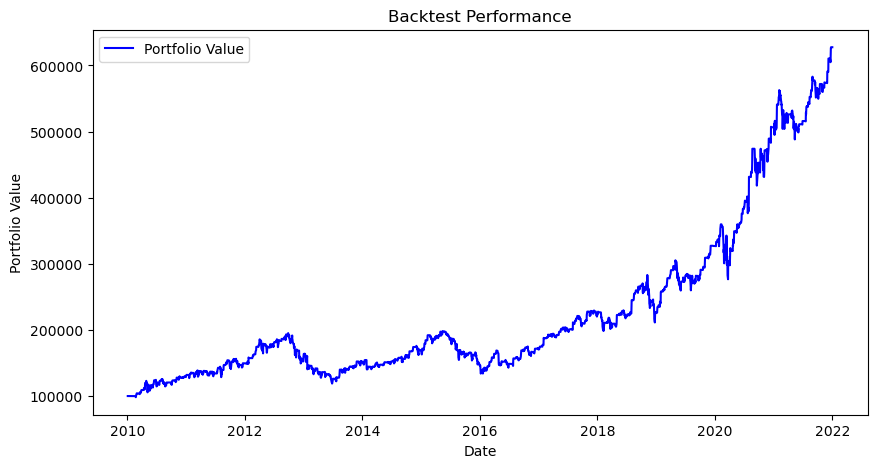

Final Value: 627545.2173
Return: 5.2755
Sharpe Ratio: 0.7974
Max Drawdown: -0.3911


In [5]:
# Backtest de la stratégie
backtest = Backtest(data, lstm_strategy)
results = backtest.run()

# Affichage des résultats
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

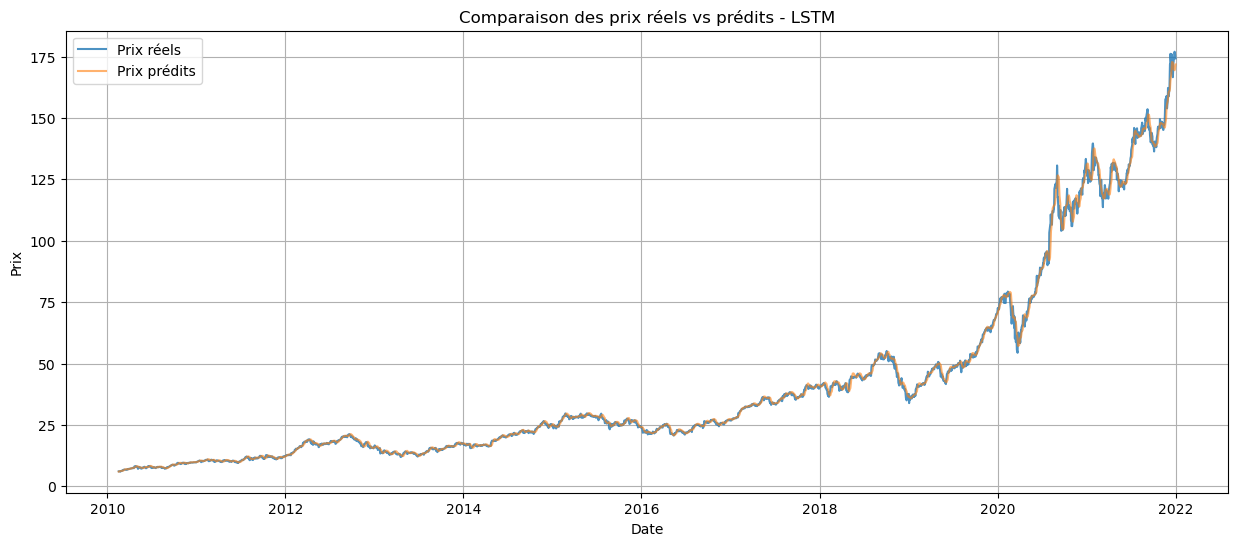

Mean Squared Error: 2.78
R² Score: 0.9981


In [ ]:
# Obtenir les prédictions et les prix réels
X, y = lstm_strategy.prepare_data(data)
predictions = lstm_strategy.generate_prediction(X)

# Inverse transform des données scaled
predictions = lstm_strategy.scaler_X.inverse_transform(predictions)
y_actual = lstm_strategy.scaler_X.inverse_transform(y)

# Création d'un DataFrame pour la visualisation
prediction_index = data.index[lstm_strategy.lookback:]
df_comparison = pd.DataFrame({
    'Actual': y_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=prediction_index)

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(df_comparison.index, df_comparison['Actual'], label='Real Prices', alpha=0.8)
plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted Prices', alpha=0.6)
plt.title('Real vs Predicted Prices - LSTM')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des métriques
mse = mean_squared_error(df_comparison['Actual'], df_comparison['Predicted'])
r2 = r2_score(df_comparison['Actual'], df_comparison['Predicted'])

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.4f}')

Multi-period

In [7]:
# Création et entraînement de la stratégie LSTM
lstm_strategy = LSTMStrategy(n_days=5, predict_returns=False)
signals = lstm_strategy.generate_signals(data)

# Affichage des scores de validation croisée
print("Cross-validation MSE scores:")
for i, score in enumerate(lstm_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(lstm_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(lstm_strategy.cv_scores):.6f}")

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores:
Fold 1: 0.000019
Fold 2: 0.000021
Fold 3: 0.000029
Fold 4: 0.000096
Fold 5: 0.000738

Mean MSE: 0.000181
Std MSE: 0.000280


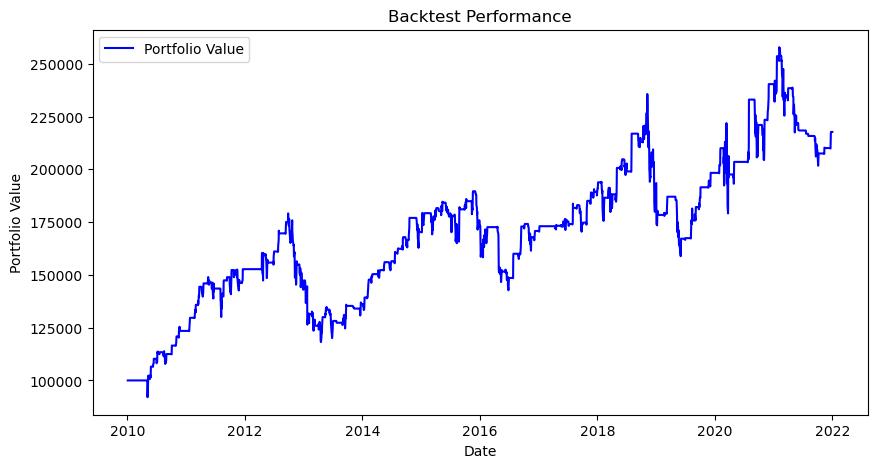

Final Value: 217720.4853
Return: 1.1772
Sharpe Ratio: 0.4341
Max Drawdown: -0.3404


In [8]:
# Backtest de la stratégie
backtest = Backtest(data, lstm_strategy)
results = backtest.run()

# Affichage des résultats
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_prediction_day(lstm_strategy, data, day_to_plot):
    if day_to_plot < 1 or day_to_plot > lstm_strategy.n_days:
        raise ValueError(f"`day_to_plot` must be between 1 and {lstm_strategy.n_days}")

    # Préparer données
    X, y = lstm_strategy.prepare_data(data)
    predictions = lstm_strategy.generate_prediction(X)

    day_idx = day_to_plot - 1  # index Python 0-based

    # Inverse transform
    if lstm_strategy.predict_returns:
        predictions = lstm_strategy.scaler_X.inverse_transform(predictions)
        y_actual = lstm_strategy.scaler_X.inverse_transform(y)

        base_prices = data['Close'].values[lstm_strategy.lookback - 1: -(lstm_strategy.n_days - 1) or None]

        pred_prices = base_prices * (1 + predictions[:, day_idx])
        actual_prices = base_prices * (1 + y_actual[:, day_idx])
    else:
        predictions = lstm_strategy.scaler_X.inverse_transform(predictions)
        y_actual = lstm_strategy.scaler_X.inverse_transform(y)

        pred_prices = predictions[:, day_idx]
        actual_prices = y_actual[:, day_idx]

    prediction_index = data.index[lstm_strategy.lookback + day_idx: lstm_strategy.lookback + day_idx + len(pred_prices)]

    # Créer le DataFrame
    df_comparison = pd.DataFrame({
        'Actual': actual_prices,
        'Predicted': pred_prices
    }, index=prediction_index)

    # Visualisation
    plt.figure(figsize=(15, 6))
    plt.plot(df_comparison.index, df_comparison['Actual'], label='Real prices', alpha=0.8)
    plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted prices', alpha=0.6)
    plt.title(f'Comparaison des prix {"(reconstruits depuis returns)" if lstm_strategy.predict_returns else ""} - Jour {day_to_plot} de prédiction')
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Métriques
    mse = mean_squared_error(df_comparison['Actual'], df_comparison['Predicted'])
    r2 = r2_score(df_comparison['Actual'], df_comparison['Predicted'])

    print(f'Mean Squared Error (Day {day_to_plot}): {mse:.2f}')
    print(f'R² Score (Day {day_to_plot}): {r2:.4f}')


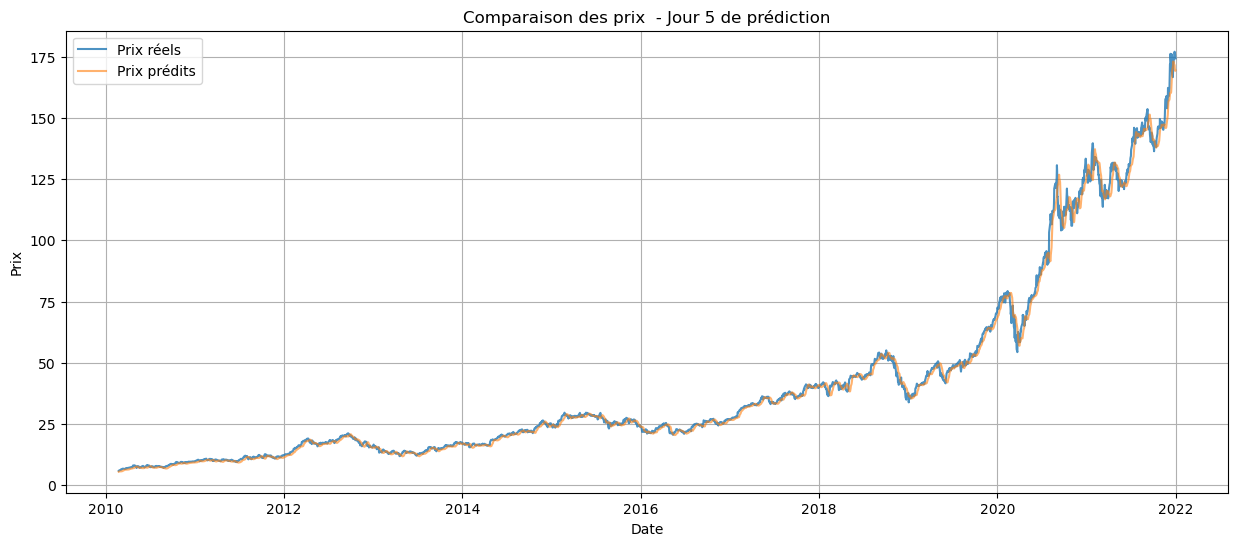

Mean Squared Error (Jour 5): 6.01
R² Score (Jour 5): 0.9958


In [10]:
plot_prediction_day(lstm_strategy, data, day_to_plot=5)


Returns

In [11]:
# Création et entraînement de la stratégie LSTM
lstm_strategy = LSTMStrategy(n_days=1, predict_returns=True)
signals = lstm_strategy.generate_signals(data)

# Affichage des scores de validation croisée
print("Cross-validation MSE scores:")
for i, score in enumerate(lstm_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(lstm_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(lstm_strategy.cv_scores):.6f}")

c:\Users\lisam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores:
Fold 1: 0.006122
Fold 2: 0.004069
Fold 3: 0.002538
Fold 4: 0.004993
Fold 5: 0.009171

Mean MSE: 0.005379
Std MSE: 0.002230


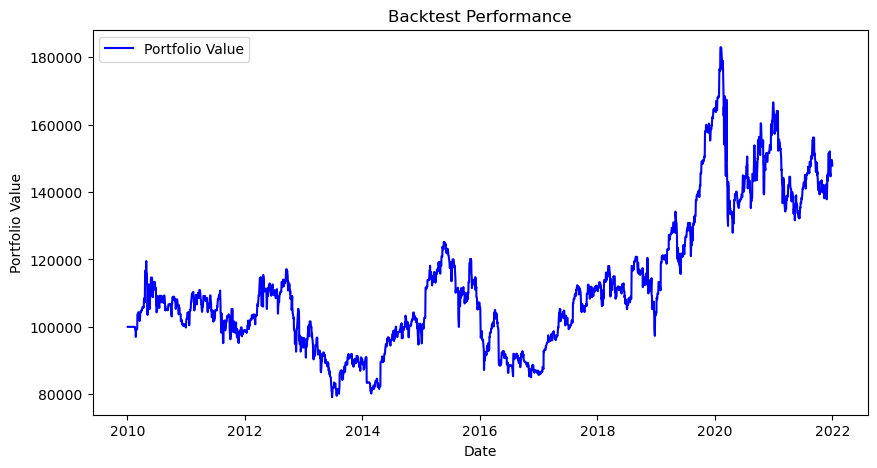

Final Value: 147864.8811
Return: 0.4786
Sharpe Ratio: 0.2582
Max Drawdown: -0.3382


In [15]:
# Backtest de la stratégie
backtest = Backtest(data, lstm_strategy)
results = backtest.run()

# Affichage des résultats
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_predicted_returns(lstm_strategy, data, day_to_plot=1):
    if not lstm_strategy.predict_returns:
        raise ValueError("Cette fonction s'applique uniquement si `predict_returns=True`.")

    if day_to_plot < 1 or day_to_plot > lstm_strategy.n_days:
        raise ValueError(f"`day_to_plot` doit être entre 1 et {lstm_strategy.n_days}.")

    # Préparation des données
    X, y = lstm_strategy.prepare_data(data)
    preds = lstm_strategy.generate_prediction(X)

    # Inverser la normalisation
    preds = lstm_strategy.scaler_X.inverse_transform(preds)
    y_true = lstm_strategy.scaler_X.inverse_transform(y)

    # Sélection du jour voulu
    pred_returns = preds[:, day_to_plot - 1]
    actual_returns = y_true[:, day_to_plot - 1]

    # Alignement des index
    index_start = lstm_strategy.lookback + day_to_plot - 1
    prediction_index = data.index[index_start: index_start + len(pred_returns)]

    # Création du DataFrame
    df_returns = pd.DataFrame({
        'Actual Return': actual_returns,
        'Predicted Return': pred_returns
    }, index=prediction_index)

    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(df_returns.index, df_returns['Actual Return'], label='Real Returns', alpha=0.8)
    plt.plot(df_returns.index, df_returns['Predicted Return'], label='Predicted Returns', alpha=0.6)
    plt.title(f'Returns - Day {day_to_plot}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Métriques d’évaluation
    mse = mean_squared_error(df_returns['Actual Return'], df_returns['Predicted Return'])
    r2 = r2_score(df_returns['Actual Return'], df_returns['Predicted Return'])

    print(f'MSE (Day {day_to_plot}): {mse:.6f}')
    print(f'R² Score (Day {day_to_plot}): {r2:.4f}')


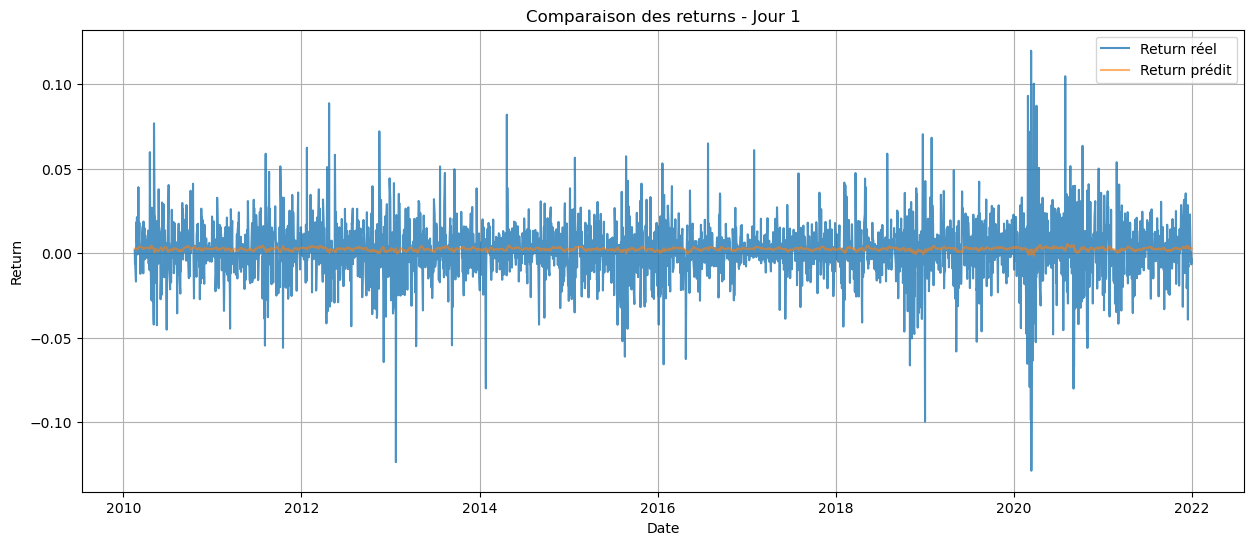

MSE (Jour 1): 0.000313
R² Score (Jour 1): -0.0066


In [13]:
plot_predicted_returns(lstm_strategy, data, day_to_plot=1)

## Comparaison des trois approches

Nous pouvons maintenant comparer les trois approches différentes :
1. Neural Network avec indicateurs techniques (Strategy 4)
2. Simple RNN (Strategy 5)
3. LSTM (Strategy 6)

Points clés à noter :
- Le LSTM utilise une architecture plus sophistiquée avec deux couches LSTM
- La première couche LSTM renvoie une séquence pour permettre à la deuxième couche de capturer des motifs plus complexes
- Le nombre de neurones (100, 50) est plus important que dans le Simple RNN pour permettre d'apprendre des motifs plus complexes

Pour une comparaison équitable, nous avons maintenu :
- La même période de données
- Le même nombre de folds pour la validation croisée
- Le même nombre d'époques d'entraînement
- La même taille de lookback (30 jours)

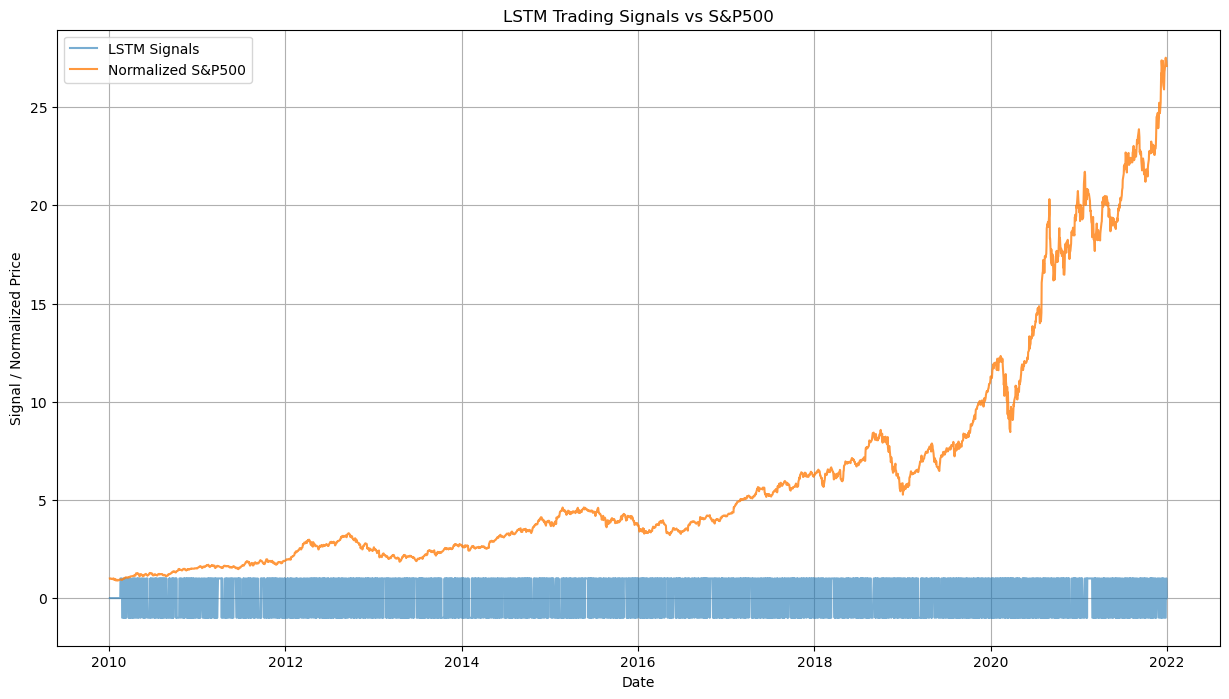

In [14]:
# Visualisation comparative des signaux
plt.figure(figsize=(15, 8))
plt.plot(data.index, signals, label='LSTM Signals', alpha=0.6)
plt.plot(data.index, data['Close'] / data['Close'].iloc[0], label='Normalized S&P500', alpha=0.8)
plt.title('LSTM Trading Signals vs S&P500')
plt.xlabel('Date')
plt.ylabel('Signal / Normalized Price')
plt.legend()
plt.grid(True)
plt.show()